### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

## Instalación

```bash
%pip install gymnasium  
%pip install gymnasium[box2d] 
```

## Acciones adicionales

Pueden ser necesarias *antes* de instalar gymnasium[box2d].

### En macos

```bash
pip uninstall swig  
xcode-select -—install (instala las herramientas de desarrollador si no se tienen ya)  
pip install swig  / sudo port install swig-python  
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas
```

### En Windows

```bash
pip install swig
```

Si da error al instalar `box2d`, se debe a la falta de la versión correcta de Microsoft C++ Build Tools, que es una dependencia de Box2D.  
Para solucionar este problema, puede seguir los siguientes pasos:
 * `%pip install --upgrade wheel setuptools`
 * Descargar Microsoft C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro del instalador, seleccione la opción "Desarrollo para el escritorio con C++"
 * Reinicie su sesión en Jupyter Notebook o en Visual Studio.
 * Ejecute nuevamente el comando `%pip install gymnasium[box2d]` en la línea de comandos de su notebook.

### En linux (colab)
```bash
pip install swig
```

In [1]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")

import numpy as np
import pygame
import gymnasium.utils.play

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}

try:
    gymnasium.utils.play.play(env, zoom=2, keys_to_action=lunar_lander_keys, noop=0)
except KeyboardInterrupt:
    pass

In [ ]:
import gymnasium as gym


def run(policy, render=None, **env_kwargs):
    env = gym.make("LunarLander-v3", render_mode=render, **env_kwargs)
    observation, info = env.reset()
    racum = 0.0
    ite = 0

    try:
        done = False
        while not done:
            ite += 1
            action = policy(observation)
            observation, reward, terminated, truncated, _ = env.step(action)
            racum += reward
            done = terminated or truncated

    finally:
        env.close()
        r = (racum + 200) / 500
        print(
            f"Episode finished after {ite} timesteps with reward {racum:.2f} (normalized: {r:.2f})"
        )

    return racum

### ¿Cómo contruir el fitness para aplicar genéticos?

 * El módulo MLP ya tiene implementado el perceptrón multicapa. Se construye con `MLP(architecture)`.
 * Architecture es una tupla (entradas, capa1, capa2, ...).
 * La función fitness toma el cromosoma del individuo y lo convierte a pesos del MLP con `model.from_chromosome(ch)`.
 * Usa `run` para $N$ casos (esto da estabilidad) y calcula el refuerzo medio.
 * Este refuerzo medio es el fitness del individuo.

In [2]:
import numpy as np
from MLP import MLP

architecture = [8, 6, 4]
model = MLP(
    architecture,
    labels=(
        ["x", "y", "vx", "vy", "θ", "ω", "leg_L", "leg_R"],
        ["Nothing", "Fire Left", "Fire Main", "Fire Right"],
    ),
)
ch = [11.503313847320436, 2.962925784515414, -0.8782385854991719, 4.0682660721593695, -2.8030312887333793, -3.003105242133109, 0.021063231735957477, 2.811980713033888, -6.608330333642787, 1.2319056084029192, -6.902051953769752, 3.8766858791135057, 14.308085022780798, 6.428493032137442, -0.6504155138628072, -0.5318942726000543, -10.295134655001927, -3.230228826393382, -8.162729157242417, 2.3453686772364057, 16.223398538656063, 46.280376425754945, -2.3389034303843053, 4.973543118152962, -38.292856498578786, -8.522213713811492, -5.968695014465945, -4.25623876563132, -7.129005844840511, 4.124017435749274, -42.222143946890796, -13.314561071959638, -20.341597570130553, -2.55261148364971, 5.342705442306577, 0.30953923475538686, -3.9368118005809114, -17.11844241968535, -4.696114708359683, 0.19699817943317788, -8.303101290600633, -26.438006426171725, -1.693499777691662, 4.885778614817008, -3.800137385630377, -2.3199709176267205, -1.3260722272129801, -7.600961190379683, -9.278644847184776, -1.047385216251885, -32.02129231841516, 7.958130456406418, 0.9154167057665918, -1.2652481183525972, 0.7464191696266489, 10.701944987464874, 4.216770030779777, -3.262222521657449, 1.9330518053465624, 9.533313125000856, -0.7146150005683761, -3.1950278457098245, -71.6704106424403, -6.052459561157419, 5.536845523986823, 3.263845995200621, 10.166137352163942, 5.178187626376466, -7.694049222367436, 4.102465473803761, -8.253900440626774, -1.3051601356354339, 1.2034359854503056, -0.5213146316559284, -0.11653298245329415, -1.7786608421879344, -1.676122049540414, 9.611430269322778, -0.6748166694225599, -2.3077793690549266, 1.152666031899553, -0.9952559642888029]
model.from_chromosome(ch)


def policy(observation):
    s = model.forward(observation)
    action = np.argmax(s)
    return action

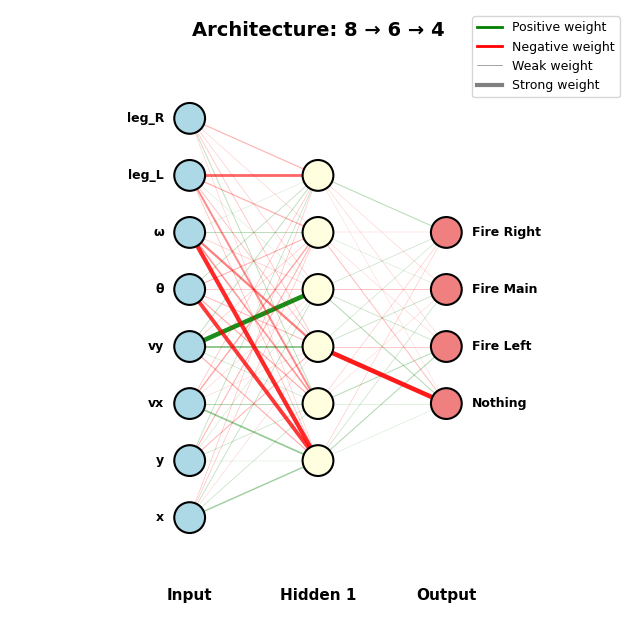

In [3]:
%matplotlib inline
fig, ax = model.plot_network()
fig;

In [4]:
N = 20
total_reward = 0.0
successes = 0
interactive = True

kwargs = dict(gravity=-10, enable_wind=False, wind_power=20.0, turbulence_power=2.5)

for c in range(N):
    if interactive:
        try:
            r = run(policy, render="human", **kwargs)
        except KeyboardInterrupt:
            interactive = False
            r = run(policy, render=None, **kwargs)
    else:
        r = run(policy, render=None, **kwargs)

    total_reward += r
    if r >= 200:
        successes += 1


print("=" * 80)
print(f"Average reward over {N} episodes: {total_reward / N:.2f}")
print(f"Number of successes (reward >= 200): {successes}")

c:\Users\Yago\Desktop\MAADM\4 Aprendizaje por Refuerzo y Técnicas Generativas\rl\.venv\Lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:245: UserWarning: WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: 2.5)
  gym.logger.warn(


Episode finished after 206 timesteps with reward 144.55 (normalized: 0.69)
Episode finished after 240 timesteps with reward 282.18 (normalized: 0.96)
Episode finished after 481 timesteps with reward 155.40 (normalized: 0.71)
Episode finished after 205 timesteps with reward 310.60 (normalized: 1.02)
Episode finished after 208 timesteps with reward 274.24 (normalized: 0.95)
Episode finished after 228 timesteps with reward 228.09 (normalized: 0.86)
Episode finished after 205 timesteps with reward 267.11 (normalized: 0.93)
Episode finished after 242 timesteps with reward 262.23 (normalized: 0.92)
Episode finished after 244 timesteps with reward 294.19 (normalized: 0.99)
Episode finished after 216 timesteps with reward 252.72 (normalized: 0.91)
Episode finished after 221 timesteps with reward 265.51 (normalized: 0.93)
Episode finished after 211 timesteps with reward 241.56 (normalized: 0.88)
Episode finished after 98 timesteps with reward 33.53 (normalized: 0.47)
Episode finished after 222 

In [ ]:
# para paralelizar el map incluso en windows
# https://github.com/joblib/loky

from loky import get_reusable_executor

executor = get_reusable_executor()

# results = executor.map(fitness, poblacion)

#### ¿No has tenido bastante?

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium
```bash
pip install flappy-bird-gymnasium
```

El código para poder ejecutarlo es el siguiente:
```python
import gymnasium as gym
import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0", use_lidar=False)
```

Estado (12 variables):
  - Posición horizontal de la última tubería
  - Posición vertical de la última tubería superior
  - Posición vertical de la última tubería inferior
  - Posición horizontal de la siguiente tubería
  - Posición vertical de la siguiente tubería superior
  - Posición vertical de la siguiente tubería inferior
  - Posición horizontal de la tubería subsiguiente
  - Posición vertical de la tubería superior subsiguiente
  - Posición vertical de la tubería inferior subsiguiente
  - Posición vertical del jugador
  - Velocidad vertical del jugador
  - Rotación del jugador

Acciones:
  * 0 -> No hacer nada
  * 1 -> Volar

In [ ]:
import gymnasium as gym
import flappy_bird_gymnasium

def run(policy, render=None, **env_kwargs):    
    env = gym.make("FlappyBird-v0", render_mode=render, **env_kwargs)
    observation, _ = env.reset()
    total_reward = 0.0
    steps = 0

    try:
        done = False
        while not done:
            action = policy(observation)
            
            observation, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
            
    finally:
        env.close()

        print(
            f"Test Finalizado | Pasos: {steps:<4} | Recompensa Total: {total_reward:.2f}"
        )

    return total_reward

"""
=========================
"""

from MLP import MLP

architecture = [12, 6, 6, 2]
model = MLP(
    architecture,
    labels=None,
)
ch = [-1.8200710943701073, -77.21645044277133, 2.6089961239985335, -225.63600717212, -861.4269617403718, -11.859284732898002, -12.882312703851241, 5.437990060880686, 20.698903344039607, 1468.2692893336568, 85.81616908873077, 122.67025306897034, -150.0735814208555, 4.735219882550151, 8.196446781500036, 30.808306804138297, 7.046784585293194, -1.647242658975901, -237.1021076397284, -12.418857088874208, -7.203250695243225, -13.954957332382016, -2231.187541738552, 1.7782412931904341, 441.9311177181282, 29.442444926419373, 20.25640683557834, -47.82204837004265, -1001.5956154029193, -58.1950113384086, -161.90200749704115, -40.001062535560294, -7.588832843730721, -17.54538715609667, -1.175992435014337, -100.57656521702371, 3.3756679367246956, -18.161908302339096, 0.6113647189562437, 60.934628308380084, -33.95936747207001, -36.63789738132571, 1088.3230716652272, 33.69121957230754, 73.81136933584526, -1095.7094618785254, 2.429231283070314, -172.18159254741218, -112.51251024605179, -2.03481579344274, -0.012941585276697408, 14.221114136434636, 243.81784866833158, -38.0239172387841, 5.172062623956749, 9.484126307680903, -3.506403271310559, -16.487162613049648, 14.073754619579873, 12.679784655972563, 5.410588256825731, 5.515523814579737, -6.564321371990446, 244.29590134298292, 11.143338333817095, -15.477804582415962, 3.8012579809303144, 179.72934804492473, 87.22230403876752, -15.12685046304609, 6.826058371697324, 0.49644081670896223, -3.4563911401998872, 26.205957128388953, 4.347725397541495, -10.433349497291733, 85.12139424445894, 17.67004311263242, 5.44721661181017, 67.79776526394755, 50.71985761071919, -2.9636964387287894, -4.367075034491667, 12.096294071100845, -563.0360366228277, 21.625196445043386, -884.0355292157249, -11.659701285595785, -11.001663737192384, 133.29563513644558, 4.621289454107552, 26.925144814760905, 9.272848007016648, -6.654484302244839, -22.81254231545715, -164.91144660472992, -30.652660774644495, 83.34629004989029, -15.15832472094302, -5.291248115387363, -0.6016009953733722, -74.35536984001196, 137.96125165253113, -4.582693700216124, 12.020508136325216, 2.674076174097152, 4.18462799242184, -130.90549799059386, 5.823085606914482, -12.929691827323792, 2.896968702567348, 16.803732236596264, -7.008586789186096, 8.37907225271046, 28.038867288064566, 5.805852642625907, 9.6200985897739, 166.23718172987373, 4.815714072046068, 4.454256586407123, -0.8827465782915527, -3.553300228070603, 13.701073706722816, 5.817498574296772, 9.943508041078413, 8.230572615118021, -18.566776036781405, -9.928044712172444, -37.35058008442648, 9.370629600525836, 9.884631673457768, -9.59197758098319, 6.696045082071515, -8.926889189699265]
model.from_chromosome(ch)


def policy(observation):
    s = model.forward(observation)
    action = np.argmax(s)
    return action

"""
=========================
"""


N = 20
total_reward = 0.0
successes = 0
interactive = True

kwargs = dict(use_lidar=False)

for c in range(N):
    if interactive:
        try:
            r = run(policy, render="human", **kwargs)
        except KeyboardInterrupt:
            interactive = False
            r = run(policy, render=None, **kwargs)
    else:
        r = run(policy, render=None, **kwargs)

    total_reward += r


print("=" * 80)
print(f"Average reward over {N} episodes: {total_reward / N:.2f}")

c:\Users\Yago\Desktop\MAADM\4 Aprendizaje por Refuerzo y Técnicas Generativas\rl\MLP.py:39: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-neta))


Test Finalizado | Pasos: 91   | Recompensa Total: 8.90
Test Finalizado | Pasos: 93   | Recompensa Total: 9.10
Test Finalizado | Pasos: 91   | Recompensa Total: 8.90
Test Finalizado | Pasos: 56   | Recompensa Total: 4.50
Test Finalizado | Pasos: 56   | Recompensa Total: 4.50
Test Finalizado | Pasos: 205  | Recompensa Total: 23.00
Test Finalizado | Pasos: 86   | Recompensa Total: 8.40
Test Finalizado | Pasos: 56   | Recompensa Total: 4.50
Test Finalizado | Pasos: 86   | Recompensa Total: 8.40
Test Finalizado | Pasos: 86   | Recompensa Total: 8.40
Test Finalizado | Pasos: 163  | Recompensa Total: 17.90
Test Finalizado | Pasos: 130  | Recompensa Total: 13.70
Test Finalizado | Pasos: 56   | Recompensa Total: 4.50
Test Finalizado | Pasos: 276  | Recompensa Total: 31.90
Test Finalizado | Pasos: 276  | Recompensa Total: 31.90
Test Finalizado | Pasos: 94   | Recompensa Total: 9.20
Test Finalizado | Pasos: 132  | Recompensa Total: 13.90
Test Finalizado | Pasos: 128  | Recompensa Total: 13.50
Tes